# Notebook 04: Modeling

This notebook covers the modeling step of the Data Science Method. Predicting the motor temperatures and torque, given time-series measurement data, is most definitely a regression problem. In notebook 02: exploratory data analysis, I saw linear, and possibly polynomial, trends between features. In addition, the research paper: https://www.researchgate.net/publication/331976678_Empirical_Evaluation_of_Exponentially_Weighted_Moving_Averages_for_Simple_Linear_Thermal_Modeling_of_Permanent_Magnet_Synchronous_Machines highlights that permanent magnet synchronous motors (PMSM) temperatures can be modeled efficiently by the use of exponentially weighted moving averages. Therefore, I'm testing the following models:

1. Linear regression
2. Ridge regression
3. Lasso regression
4. Polynomial regression
5. Exponentially Weighted Moving Average regression

To compare the different models, the following metrics will be compared:

1. Coefficient of Determination (R-Squared)
2. Root Squared Mean Error (RMSE)

The overview of the notebook is highlighted below.

## Overview
1. Load modules, load data, scale data, define functions
2. Linear regression model
3. Ridge regression model
4. LASSO regression model
5. Polynomial regression model
6. EWMA regression model
7. Conclusion

### Load Modules

In [109]:
# imports
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt, rcParams
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import random
import time

### Load Train and Test Data

In [2]:
# load training data
X_train = pd.read_csv('..\data\X_train.csv')
y_train = pd.read_csv('..\data\y_train.csv')

# load testing data
X_test = pd.read_csv('..\data\X_test.csv')
y_test = pd.read_csv('..\data\y_test.csv')

# set profile_id and runtime as multi-index (index not saved when loading from csv)
X_train.set_index(['profile_id','runtime'], inplace=True)
y_train.set_index(['profile_id','runtime'], inplace=True)

X_test.set_index(['profile_id','runtime'], inplace=True)
y_test.set_index(['profile_id','runtime'], inplace=True)

In [3]:
# view feature data
X_train.head()

u_q    coolant       u_d  motor_speed       i_d  \
profile_id runtime                                                         
16         0.0     -0.290354  18.757370  0.452413    -0.001865 -1.970345   
           0.5     -0.375260  18.747351  0.467819     0.004591 -1.976117   
           1.0     -0.420636  18.707191  0.716038    -0.002337 -1.979344   
           1.5     -0.470669  18.671671  0.725096    -0.001631 -1.739247   
           2.0     -0.501587  18.646217  0.810236    -0.005415 -1.813314   

                         i_q    ambient  
profile_id runtime                       
16         0.0      1.080167  24.913349  
           0.5      1.083688  24.941618  
           1.0      1.086039  24.994671  
           1.5      0.951236  25.006641  
           2.0      0.992231  24.975666

In [4]:
# view target data
y_train.head()

stator_winding  stator_tooth  stator_yoke         pm  \
profile_id runtime                                                         
16         0.0           19.254295     18.528898    18.715153  23.860319   
           0.5           19.250660     18.524143    18.709347  23.869778   
           1.0           19.249020     18.517841    18.717850  23.871521   
           1.5           19.243021     18.517654    18.724812  23.863602   
           2.0           19.240652     18.522953    18.698622  23.861328   

                      torque  
profile_id runtime            
16         0.0      1.176523  
           0.5      1.282476  
           1.0      1.349741  
           1.5      1.419969  
           2.0      1.484768

Note that the train and test data has not yet been standardized. To keep the target variables in relevant units, only the feature variables will be scaled.

### Standardize train and test datasets based on the training data

In [5]:
# instantiate a StandardScaler() and fit to training data
scaler = StandardScaler().fit(X_train)

# transform both training and testing dataframes using the scaler (subscript _s will denote the data has been scaled)
X_train_s = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [6]:
# view scaled feature data
X_train_s.head()

u_q   coolant       u_d  motor_speed       i_d  \
profile_id runtime                                                        
16         0.0     -1.227481 -0.861123  0.366904    -1.207337  1.032631   
           0.5     -1.229370 -0.861578  0.367144    -1.207333  1.032543   
           1.0     -1.230379 -0.863402  0.371019    -1.207337  1.032493   
           1.5     -1.231492 -0.865015  0.371161    -1.207337  1.036174   
           2.0     -1.232180 -0.866171  0.372490    -1.207339  1.035038   

                         i_q   ambient  
profile_id runtime                      
16         0.0     -0.337218  0.100653  
           0.5     -0.337180  0.115432  
           1.0     -0.337155  0.143168  
           1.5     -0.338601  0.149426  
           2.0     -0.338161  0.133233

### Functions

In [7]:
# function to return a DataFrame of model scoring metrics per target feature
def target_scores(y_true, y_pred):
    # initialize lists
    target_list = []
    metric_list = []
    score_list = []
        
    metrics = ['r2', 'rmse']
    
    for metric in metrics:
        # get scores
        if metric=='r2':
            scores = r2_score(y_true, y_pred, multioutput='raw_values')
        if metric=='rmse':
            scores = mean_squared_error(y_true, y_pred, squared=False, multioutput='raw_values')
        
        for ind, target in enumerate(y_true.columns):
            # append lists
            target_list.append(target)
            metric_list.append(metric)
            score_list.append(scores[ind])
        
    return pd.DataFrame({'target':target_list, 'metric':metric_list, 'score':score_list})

# function to score each profile_id's model prediction independently
def get_session_scores(X, y, model):
    # get unique sessions
    sessions = y.index.get_level_values(0).unique()
    
    # initialize list
    df_list = []
    
    for ind, session in enumerate(sessions):
        # get metrics
        scores_df = target_scores(y.loc[session,:], model.predict(X.loc[session,:]))
        
        # add session column
        scores_df['profile_id'] = session
        
        # append list
        df_list.append(scores_df)
        
    return pd.concat(df_list, axis=0, ignore_index=True)

# function to create len(spans) EWMA features for each original feature given spans for each new feature
def create_EWMA_feature(df, spans=None):
    ewma_df = pd.concat([df.ewm(span=s).mean().rename(columns=lambda c: f'{c}_ewma_{s}') for s in spans], axis=1)
    return pd.concat([df, ewma_df], axis=1)

# function to filter the parameter grid and return only unique non-repeating combinations of parameters
def get_filtered_param_grid(pgrid):
    # make it a dataframe
    pgrid_df = pd.DataFrame(pgrid)

    # add a column for the sum of the feature spans, and the number of unique spans
    sum_values = pgrid_df.agg(sum, axis=1)

    def len_of_unique_values(a):
        return len(np.unique(a))

    unique_values = pgrid_df.agg(len_of_unique_values, axis=1)

    pgrid_df['sum'] = sum_values
    pgrid_df['unique'] = unique_values

    # view dataframe
    pgrid_df.head()

    # filter dataframe
    return pgrid_df[pgrid_df['unique']==4].drop_duplicates(subset=['sum']).drop(['sum','unique'], axis=1)

## Linear Regression

In [8]:
# instantiate a linear model
linear_model = LinearRegression()

# fit model to training data
linear_model.fit(X_train_s, y_train)

# get metrics for each session
train_scores = get_session_scores(X_train_s, y_train, linear_model)
test_scores = get_session_scores(X_test_s, y_test, linear_model)

# add categories
train_scores['set'] = 'train'
test_scores['set'] = 'test'

# combine train and test scores
lr_scores = pd.concat([train_scores, test_scores], axis=0, ignore_index=True)

In [9]:
# view dataframe before plotting
lr_scores

,target,metric,score,profile_id,set
0,stator_winding,r2,0.772904,16,train
1,stator_tooth,r2,0.652363,16,train
2,stator_yoke,r2,0.610023,16,train
3,pm,r2,-0.687495,16,train
4,torque,r2,0.999778,16,train
...,...,...,...,...,...
685,stator_winding,rmse,17.164273,61,test
686,stator_tooth,rmse,12.063713,61,test
687,stator_yoke,rmse,7.788310,61,test
688,pm,rmse,10.909093,61,test


### Create a box plot of session prediction scores

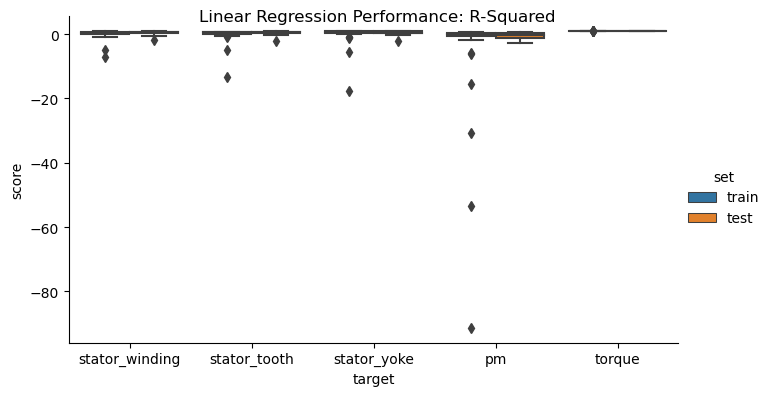

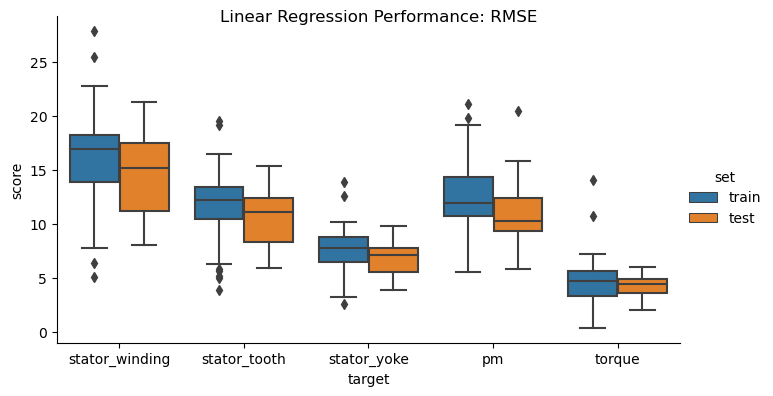

In [10]:
# create metric-specific dataframes for plotting
lr_score_r2 = lr_scores[lr_scores['metric']=='r2']
lr_score_rmse = lr_scores[lr_scores['metric']=='rmse']

# plot
sns.catplot(kind='box', data=lr_score_r2, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('Linear Regression Performance: R-Squared')
plt.show()

sns.catplot(kind='box', data=lr_score_rmse, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('Linear Regression Performance: RMSE')
plt.show()

For quite a few measurement sessions, an ordinary least squares regression model produces negative R-Squared scores for all the target temperatures (i.e. the model is predicting worse than the mean of the target values).

## Ridge Regression (L2 Regularization)
Ridge shrinks the magnitude of coefficients towards zero, reducing multicollinearity.

In [11]:
# instantiate a Ridge model
ridge = Ridge()

# define hyperparameter
n_alphas = 200
alphas = np.logspace(-10, 10, n_alphas)
parameters = {'alpha':alphas}

# instantiate a grid search with cross-validation
ridge_model = GridSearchCV(ridge, param_grid=parameters, cv=5)

# train and test model on training data to find best hyperparameter
ridge_model.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8....
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10])})

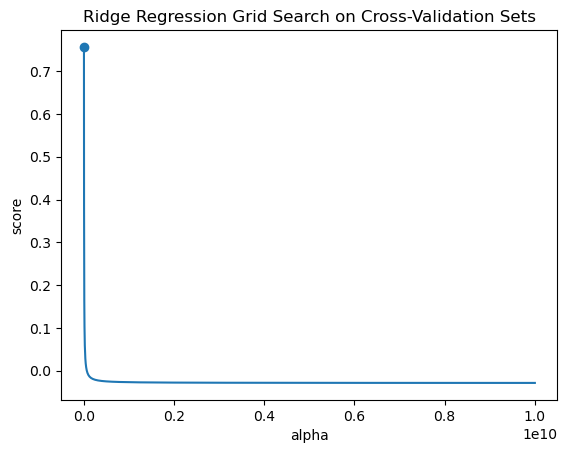

In [12]:
# view the hyperparameter scoring
plt.plot(ridge_model.param_grid['alpha'], ridge_model.cv_results_['mean_test_score'])
plt.scatter(ridge_model.best_params_['alpha'], ridge_model.best_score_)
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('Ridge Regression Grid Search on Cross-Validation Sets')
plt.show()

In [13]:
# get metrics for each session
train_scores = get_session_scores(X_train_s, y_train, ridge_model)
test_scores = get_session_scores(X_test_s, y_test, ridge_model)

# add categories
train_scores['set'] = 'train'
test_scores['set'] = 'test'

# combine train and test scores
ridge_scores = pd.concat([train_scores, test_scores], axis=0, ignore_index=True)

In [14]:
# view dataframe before plotting
ridge_scores

,target,metric,score,profile_id,set
0,stator_winding,r2,0.762729,16,train
1,stator_tooth,r2,0.637692,16,train
2,stator_yoke,r2,0.589691,16,train
3,pm,r2,-0.708357,16,train
4,torque,r2,0.999599,16,train
...,...,...,...,...,...
685,stator_winding,rmse,17.137777,61,test
686,stator_tooth,rmse,12.047435,61,test
687,stator_yoke,rmse,7.792012,61,test
688,pm,rmse,10.877618,61,test


### Create a box plot of session prediction scores

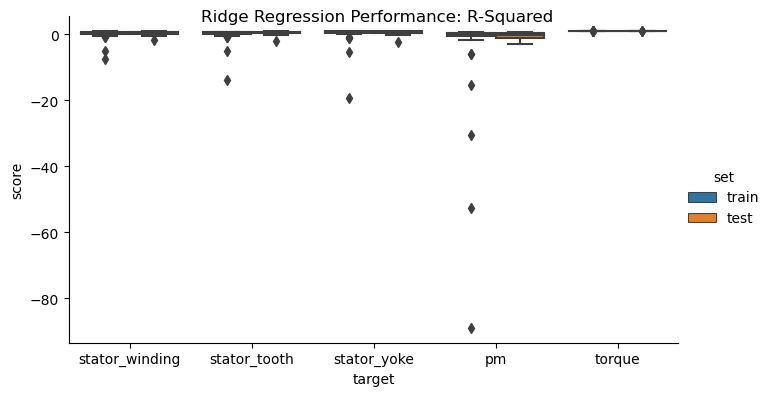

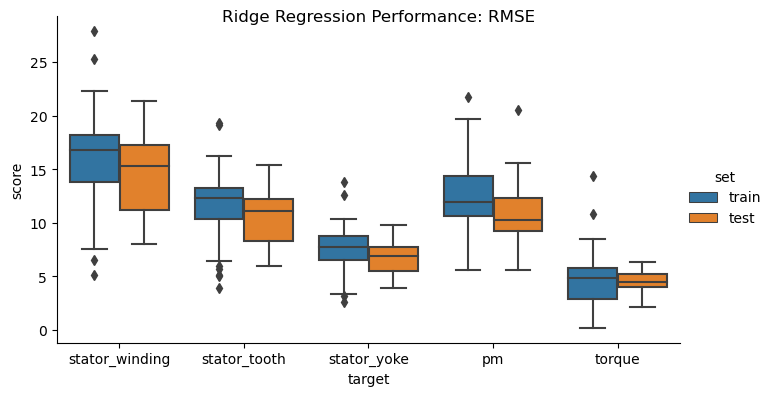

In [15]:
# create metric-specific dataframes for plotting
ridge_score_r2 = ridge_scores[ridge_scores['metric']=='r2']
ridge_score_rmse = ridge_scores[ridge_scores['metric']=='rmse']

# plot
sns.catplot(kind='box', data=ridge_score_r2, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('Ridge Regression Performance: R-Squared')
plt.show()

sns.catplot(kind='box', data=ridge_score_rmse, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('Ridge Regression Performance: RMSE')
plt.show()

Ridge regression still produces negative R-Squared scores for the motor temperature predictions just as the linear regression model had. The Root Mean Squared Error is roughly the same as the prior model as well.

In [16]:
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train_s, y_train['pm'])
    coefs.append(ridge.coef_)

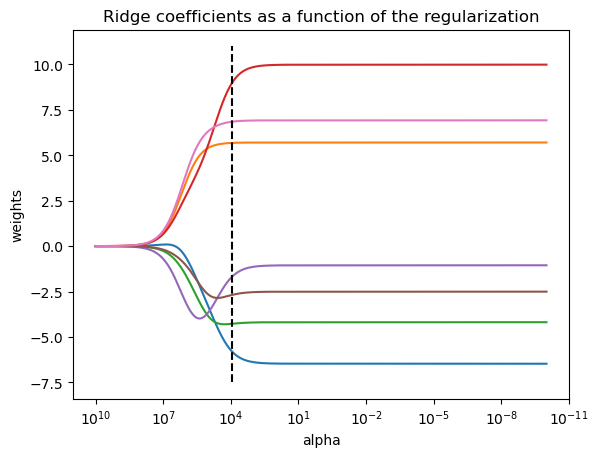

In [17]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.vlines(ridge_model.best_params_['alpha'], ymin=-7.5, ymax=11, linestyles='--', color='black')
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

The above plot shows how the weights on the ridge regression coefficients change with alpha, the penalty term. The optimal alpha is shown as the dotted line. As alpha approaches zero, the ordinary least squares model is achieved (no penalty term).

## LASSO Regression (L1 Regularization)
Lasso (Least Absolute Shrinkage Selector Operator) automatically does feature selection by shrinking coefficients to zero.

In [18]:
# instantiate a LASSO model
lasso = Lasso()

# define hyperparameter
n_alphas = 200
alphas = np.logspace(-10, 10, n_alphas)
parameters = {'alpha':alphas}

# instantiate a grid search with cross-validation
lasso_model = GridSearchCV(lasso, param_grid=parameters, cv=5)

# train and test model on training data to find best hyperparameter
lasso_model.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8....
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10])})

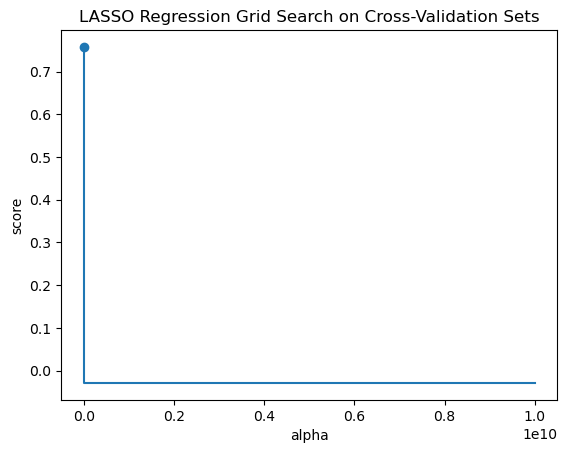

In [19]:
# view the hyperparameter scoring
plt.plot(lasso_model.param_grid['alpha'], lasso_model.cv_results_['mean_test_score'])
plt.scatter(lasso_model.best_params_['alpha'], lasso_model.best_score_)
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('LASSO Regression Grid Search on Cross-Validation Sets')
plt.show()

In [20]:
# get metrics for each session
train_scores = get_session_scores(X_train_s, y_train, lasso_model)
test_scores = get_session_scores(X_test_s, y_test, lasso_model)

# add categories
train_scores['set'] = 'train'
test_scores['set'] = 'test'

# combine train and test scores
lasso_scores = pd.concat([train_scores, test_scores], axis=0, ignore_index=True)

In [21]:
# view dataframe before plotting
lasso_scores

,target,metric,score,profile_id,set
0,stator_winding,r2,0.755719,16,train
1,stator_tooth,r2,0.633887,16,train
2,stator_yoke,r2,0.573539,16,train
3,pm,r2,-0.852381,16,train
4,torque,r2,0.999868,16,train
...,...,...,...,...,...
685,stator_winding,rmse,17.022307,61,test
686,stator_tooth,rmse,11.929146,61,test
687,stator_yoke,rmse,7.707257,61,test
688,pm,rmse,10.746972,61,test


### Create a box plot of session prediction scores

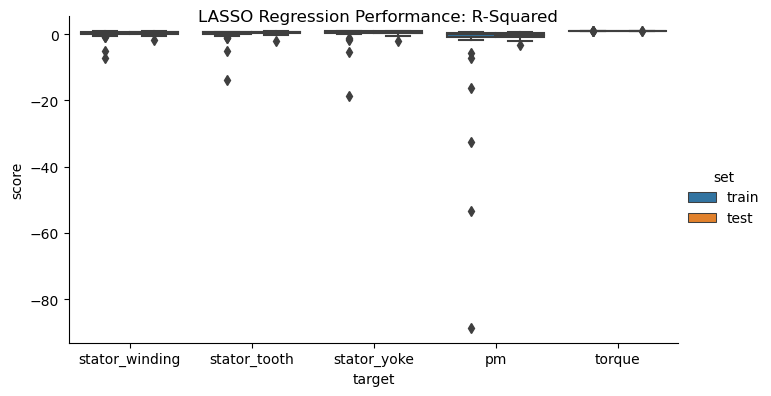

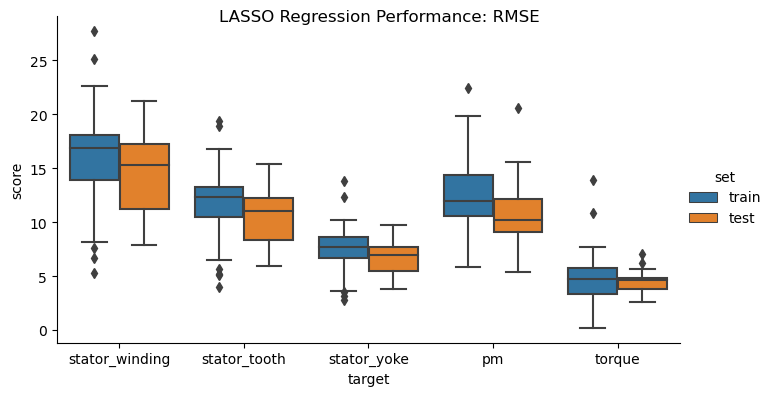

In [22]:
# create metric-specific dataframes for plotting
lasso_score_r2 = lasso_scores[lasso_scores['metric']=='r2']
lasso_score_rmse = lasso_scores[lasso_scores['metric']=='rmse']

# plot
sns.catplot(kind='box', data=lasso_score_r2, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('LASSO Regression Performance: R-Squared')
plt.show()

sns.catplot(kind='box', data=lasso_score_rmse, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('LASSO Regression Performance: RMSE')
plt.show()

LASSO regression looks to perform roughly as well as the Ridge regression in the previous model.

## Polynomial Regression
Polynomial regression is a linear regression on polynomial features of the original features of the feature dataset.

In [23]:
# create a pipeline
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())

# define hyperparameter
degrees = np.arange(1,5)
parameters = {'polynomialfeatures__degree':degrees}

# instantiate a grid search with cross-validation
polynomial_model = GridSearchCV(pipeline, param_grid=parameters, cv=5)

# train and test model on training data to find best hyperparameter
polynomial_model.fit(X_train_s, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([1, 2, 3, 4])})

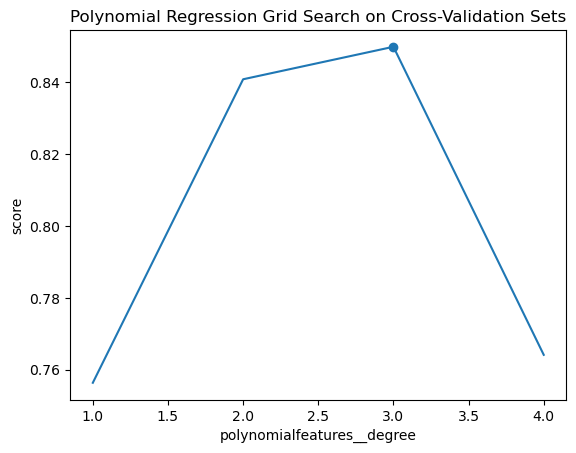

In [24]:
# view the hyperparameter scoring
plt.plot(polynomial_model.param_grid['polynomialfeatures__degree'], polynomial_model.cv_results_['mean_test_score'])
plt.scatter(polynomial_model.best_params_['polynomialfeatures__degree'], polynomial_model.best_score_)
plt.xlabel('polynomialfeatures__degree')
plt.ylabel('score')
plt.title('Polynomial Regression Grid Search on Cross-Validation Sets')
plt.show()

In [25]:
# get metrics for each session
train_scores = get_session_scores(X_train_s, y_train, polynomial_model)
test_scores = get_session_scores(X_test_s, y_test, polynomial_model)

# add categories
train_scores['set'] = 'train'
test_scores['set'] = 'test'

# combine train and test scores
poly_scores = pd.concat([train_scores, test_scores], axis=0, ignore_index=True)

In [26]:
# view dataframe before plotting
poly_scores

,target,metric,score,profile_id,set
0,stator_winding,r2,0.907173,16,train
1,stator_tooth,r2,0.871260,16,train
2,stator_yoke,r2,0.853357,16,train
3,pm,r2,0.466486,16,train
4,torque,r2,0.999828,16,train
...,...,...,...,...,...
685,stator_winding,rmse,10.786540,61,test
686,stator_tooth,rmse,7.354049,61,test
687,stator_yoke,rmse,5.010984,61,test
688,pm,rmse,6.868510,61,test


### Create a box plot of session prediction scores

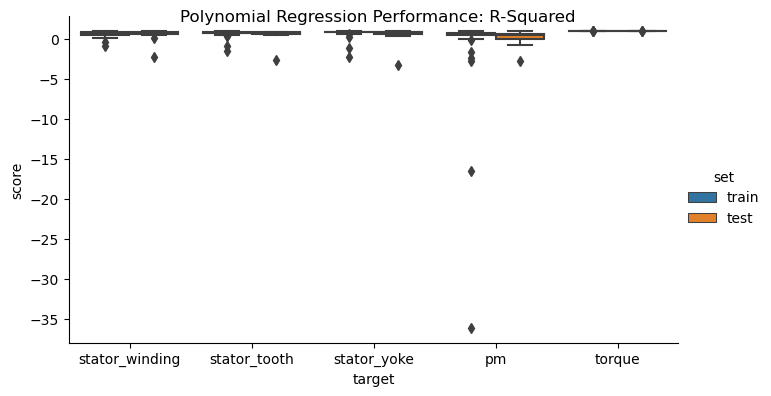

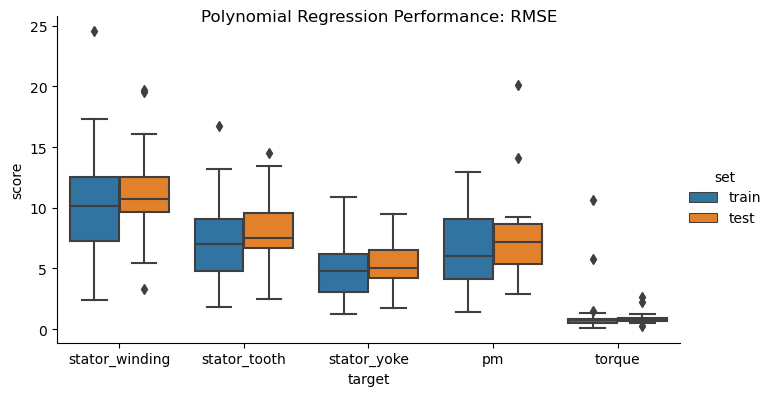

In [27]:
# create metric-specific dataframes for plotting
poly_score_r2 = poly_scores[poly_scores['metric']=='r2']
poly_score_rmse = poly_scores[poly_scores['metric']=='rmse']

# plot
sns.catplot(kind='box', data=poly_score_r2, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('Polynomial Regression Performance: R-Squared')
plt.show()

sns.catplot(kind='box', data=poly_score_rmse, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('Polynomial Regression Performance: RMSE')
plt.show()

Polynomial regression does show an improvement compared to the various models tested above. However, negative R-Squared scores are still being seen for all targets except torque. At this point it can be seen that two separate models should be used: one model for predicting torque and another model for predicting temperature.

## Exponentially Weighted Moving Average (EWMA) Regression
Creating EWMA features in a preprocessing step prior to fitting to a linear regression model is the method recommended by the research paper mentioned in the beginning of this notebook.

The previous models had at most one hyperparameter to tune. This EWMA method will have two parameters:
1. how many EWMA features to choose
2. the spans for each feature

Since, there is a very high number of possible combinations for the hyperparameters, a repeated random sample for spans for each EWMA feature can be done to get a distribution of results. From this distribution of results, the optimal number of EWMA features can be chosen and then the best combination of spans can be chosen.

### Let's first determine the number of EWMA features to choose

In [28]:
t0 = time.time()

# study inputs
n_feat_bounds = [1, 11]  # [inclusive,exclusive), range of number of features to test (iterated)
spans_min_bounds = [1, 60]  # inclusive, bounds of possible span values for EWMA (randomly draw) (in minutes)
repetitions = 30  # number of times random feature spans are tested per number of features

# initialize recorded data lists
n_feat_list = []
rep_list = []
spans_list = []
mse_list = []

for idx, n_feat in enumerate(range(n_feat_bounds[0], n_feat_bounds[1])):
    for rep in range(1, repetitions+1):
        # get n_feat random spans
        random_spans = [random.randint(spans_min_bounds[0], spans_min_bounds[1])*60*2 for n in range(1,n_feat+1)]  # *60seconds*2Hz
        
        # get EWMA features
        X_train_s_EWMA = create_EWMA_feature(X_train_s, spans=random_spans)
        X_test_s_EWMA = create_EWMA_feature(X_test_s, spans=random_spans)
        
        # train linear model on EWMA features
        model = LinearRegression().fit(X_train_s_EWMA, y_train)

        # record
        n_feat_list.append(n_feat)
        rep_list.append(rep)
        spans_list.append(random_spans)
        mse_list.append(mean_squared_error(y_test, model.predict(X_test_s_EWMA)))
        
    # progress update
    print('completed feature %i of %i' % (idx+1, max(n_feat_bounds)-1))

# put together final dataframe
results = pd.DataFrame({'n_feat' : n_feat_list,
                        'rep' : rep_list,
                        'spans' : spans_list,
                        'mse' : mse_list})

t1 = time.time()
print('elapsed time: %f' % (t1-t0))

completed feature 1 of 10
completed feature 2 of 10
completed feature 3 of 10
completed feature 4 of 10
completed feature 5 of 10
completed feature 6 of 10
completed feature 7 of 10
completed feature 8 of 10
completed feature 9 of 10
completed feature 10 of 10
elapsed time: 707.862278


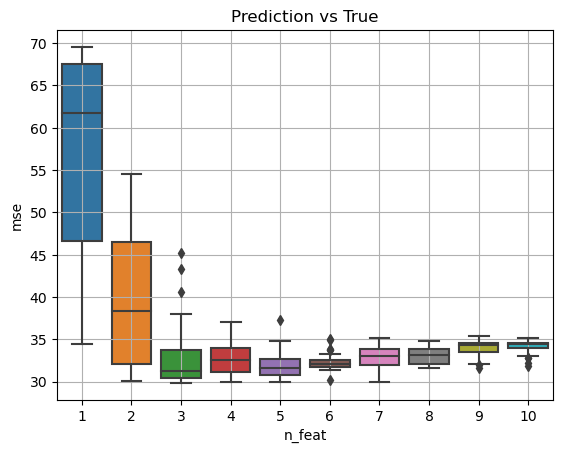

In [29]:
sns.boxplot(data=results, x='n_feat', y='mse')
plt.grid(True)
plt.title('Prediction vs True')
plt.show()

The EWMA model appears to be predicting the best when it has 4-5 EWMA features. It is also noted, that as the number of features increase, the span chosen for each feature has less of an impact on the models accuracy (the spread of the data decreases with number of features).

Since torque is already being predicted well, let's focus on predicting just the temperatures.

In [30]:
t0 = time.time()

# study inputs
n_feat_bounds = [1, 11]  # [inclusive,exclusive), range of number of features to test (iterated)
spans_min_bounds = [1, 60]  # inclusive, bounds of possible span values for EWMA (randomly draw) (in minutes)
repetitions = 30  # number of times random feature spans are tested per number of features

# initialize recorded data lists
n_feat_list = []
rep_list = []
spans_list = []
mse_list = []

for idx, n_feat in enumerate(range(n_feat_bounds[0], n_feat_bounds[1])):
    for rep in range(1, repetitions+1):
        # get n_feat random spans
        random_spans = [random.randint(spans_min_bounds[0], spans_min_bounds[1])*60*2 for n in range(1,n_feat+1)]  # *60seconds*2Hz
        
        # get EWMA features
        X_train_s_EWMA = create_EWMA_feature(X_train_s, spans=random_spans)
        X_test_s_EWMA = create_EWMA_feature(X_test_s, spans=random_spans)
        
        # train linear model on EWMA features
        model = LinearRegression().fit(X_train_s_EWMA, y_train.drop('torque', axis=1))

        # record
        n_feat_list.append(n_feat)
        rep_list.append(rep)
        spans_list.append(random_spans)
        mse_list.append(mean_squared_error(y_test.drop('torque', axis=1), model.predict(X_test_s_EWMA)))
        
    # progress update
    print('completed feature %i of %i' % (idx+1, max(n_feat_bounds)-1))

# put together final dataframe
results2 = pd.DataFrame({'n_feat' : n_feat_list,
                        'rep' : rep_list,
                        'spans' : spans_list,
                        'mse' : mse_list})

t1 = time.time()
print('elapsed time: %f' % (t1-t0))

completed feature 1 of 10
completed feature 2 of 10
completed feature 3 of 10
completed feature 4 of 10
completed feature 5 of 10
completed feature 6 of 10
completed feature 7 of 10
completed feature 8 of 10
completed feature 9 of 10
completed feature 10 of 10
elapsed time: 693.910024


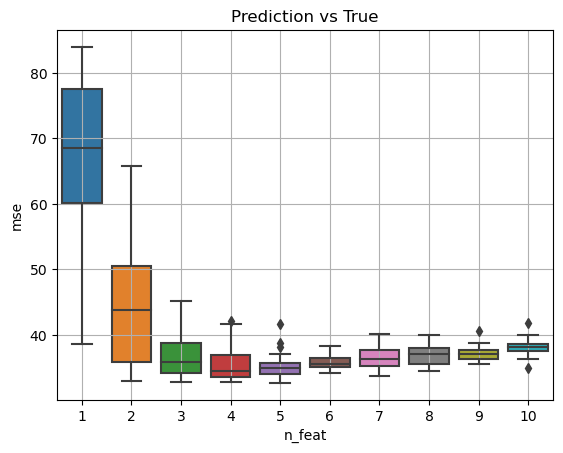

In [31]:
sns.boxplot(data=results2, x='n_feat', y='mse')
plt.grid(True)
plt.title('Prediction vs True')
plt.show()

When running the tests again but this time with only temperatures, the model scores did get worse, but this was expected due to torque being predicted well in all models so far. The other thing to note is that the optimal number of features appears to be four.

Now that we know how many features to collect, we need to determine the best span values for the four features.

### Plot the results vs the values for span (4 features)

In [32]:
t0 = time.time()

parameters = {'feat1':range(1,61),
              'feat2':range(1,61),
              'feat3':range(1,61),
              'feat4':range(1,61)}

# get a filtered parameter grid (unique non-repeating combinations)
pgrid_df_filtered = get_filtered_param_grid(ParameterGrid(parameters))

# initialize lists
spans_list = []
mse_list = []

for ind, data in pgrid_df_filtered.iterrows():
    # get spans
    spans_minutes = [data['feat1'], data['feat2'], data['feat3'], data['feat4']]
    spans = [i*60*2 for i in spans_minutes]
    
    # get EWMA features
    X_train_s_EWMA = create_EWMA_feature(X_train_s, spans=spans)
    X_test_s_EWMA = create_EWMA_feature(X_test_s, spans=spans)
    
    # train linear model on EWMA features
    model = LinearRegression().fit(X_train_s_EWMA, y_train.drop('torque', axis=1))
    
    #record
    spans_list.append(spans)
    mse_list.append(mean_squared_error(y_test.drop('torque', axis=1), model.predict(X_test_s_EWMA)))

# put together final dataframe
results3 = pd.DataFrame({'spans' : spans_list,
                         'mse' : mse_list})
t1 = time.time()
print('elapsed time: %f' % (t1-t0))

elapsed time: 557.004122


In [33]:
results3.head()

,spans,mse
0,"[120, 240, 360, 480]",35.798220
1,"[120, 240, 360, 600]",35.144491
2,"[120, 240, 360, 720]",34.616335
3,"[120, 240, 360, 840]",34.190597
4,"[120, 240, 360, 960]",33.849567


### Get a 1-dimensional array of span values

In [34]:
spans_list = []
mse_list = []

for index, data in results3.sort_values(by='mse', ascending=True).iterrows():
    for value in data['spans']:
        spans_list.append(value)
        mse_list.append(data['mse'])

results_1d = pd.DataFrame({'spans' : spans_list, 'mse' : mse_list})
results_1d.head()

,spans,mse
0,120,32.901698
1,240,32.901698
2,360,32.901698
3,1920,32.901698
4,120,32.908350


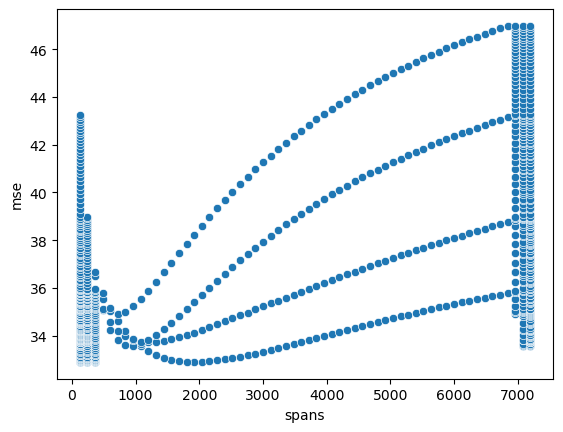

In [35]:
sns.scatterplot(data=results_1d, x='spans', y='mse')
plt.show()

According to the plot above, the features that have spans closer to 0, meaning the most recent information, tend to score better than those that use old information. This intuitively makes sense. The temperature should be most affected by recent actions in the motor and not the really old actions.

### Determine the best span values for 4 features, given the tests ran above.

In [36]:
results3.sort_values(by='mse', ascending=True).head(3)

,spans,mse
12,"[120, 240, 360, 1920]",32.901698
13,"[120, 240, 360, 2040]",32.908350
11,"[120, 240, 360, 1800]",32.912446


The best spans for the four features are 1, 2, 3 and 16 minutes. Let's see how well the target temperatures are predicted using these hyperparamters for the EWMA model.

In [37]:
# create the spans array
spans = [i*60*2 for i in [1, 2, 3, 16]]  # *60seconds*2Hz

# get EWMA features
X_train_s_ewma = create_EWMA_feature(X_train_s, spans=spans)
X_test_s_ewma = create_EWMA_feature(X_test_s, spans=spans)

# train linear model on EWMA features
ewma_model = LinearRegression().fit(X_train_s_ewma, y_train)

# get metrics for each session
train_scores = get_session_scores(X_train_s_ewma, y_train, ewma_model)
test_scores = get_session_scores(X_test_s_ewma, y_test, ewma_model)

# add categories
train_scores['set'] = 'train'
test_scores['set'] = 'test'

# combine train and test scores
ewma_scores = pd.concat([train_scores, test_scores], axis=0, ignore_index=True)

In [38]:
# view dataframe before plotting
ewma_scores

,target,metric,score,profile_id,set
0,stator_winding,r2,0.962654,16,train
1,stator_tooth,r2,0.947659,16,train
2,stator_yoke,r2,0.939141,16,train
3,pm,r2,0.469413,16,train
4,torque,r2,0.999754,16,train
...,...,...,...,...,...
685,stator_winding,rmse,4.469039,61,test
686,stator_tooth,rmse,3.607853,61,test
687,stator_yoke,rmse,2.583655,61,test
688,pm,rmse,5.878406,61,test


### Create a box plot of session prediction scores

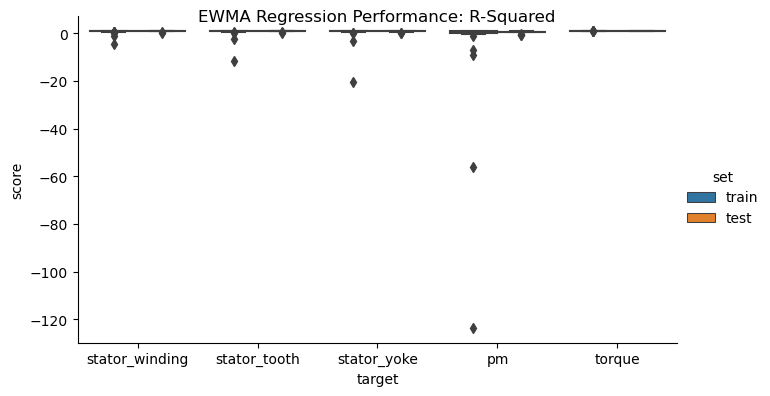

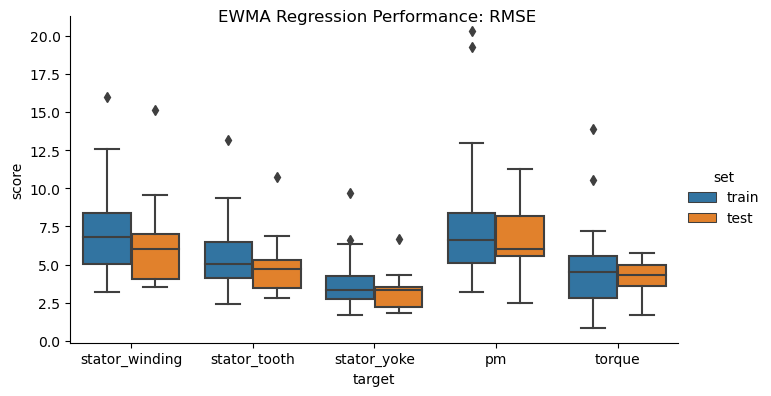

In [39]:
# create metric-specific dataframes for plotting
ewma_score_r2 = ewma_scores[ewma_scores['metric']=='r2']
ewma_score_rmse = ewma_scores[ewma_scores['metric']=='rmse']

# plot
sns.catplot(kind='box', data=ewma_score_r2, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('EWMA Regression Performance: R-Squared')
plt.show()

sns.catplot(kind='box', data=ewma_score_rmse, x='target', y='score', hue='set', height=4, aspect=1.75)
plt.suptitle('EWMA Regression Performance: RMSE')
plt.show()

Although there are still a few outliers that produce negative R-Squared scores, the Exponentially Weighted Moving Average regression model definitely out-performs the other models.

## Conclusion

The plot below shows how each of the models compare:

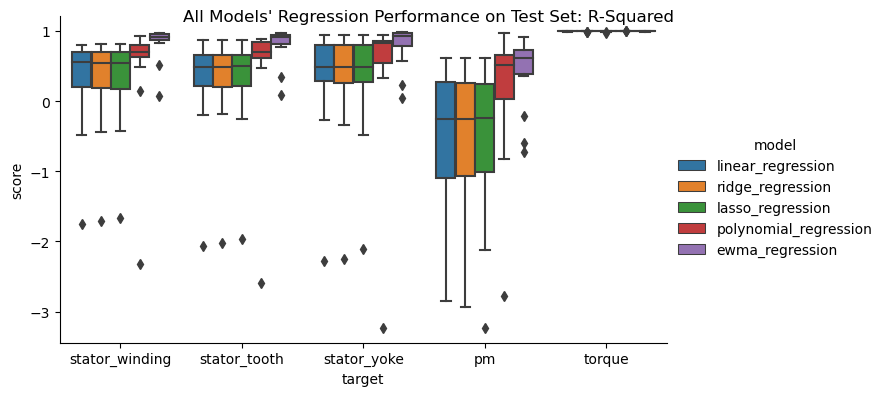

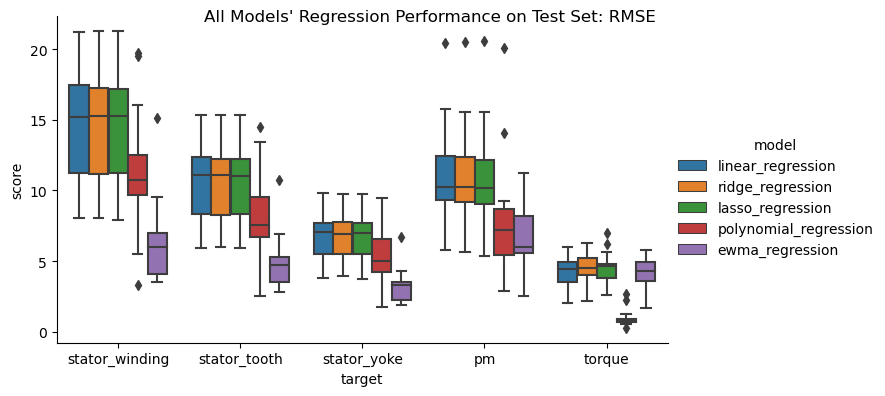

In [40]:
# combine all model scores
lr_scores['model'] = 'linear_regression'
ridge_scores['model'] = 'ridge_regression'
lasso_scores['model'] = 'lasso_regression'
poly_scores['model'] = 'polynomial_regression'
ewma_scores['model'] = 'ewma_regression'

all_scores = pd.concat([lr_scores, ridge_scores, lasso_scores, poly_scores, ewma_scores], axis=0, ignore_index=True)

# create metric-specific dataframes for plotting
all_scores_r2 = all_scores[all_scores['metric']=='r2']
all_scores_rmse = all_scores[all_scores['metric']=='rmse']
all_test_scores_r2 = all_scores_r2[all_scores_r2['set']=='test']
all_test_scores_rmse = all_scores_rmse[all_scores_rmse['set']=='test']

# plot
sns.catplot(kind='box', data=all_test_scores_r2, x='target', y='score', hue='model', height=4, aspect=1.75)
plt.suptitle('All Models\' Regression Performance on Test Set: R-Squared')
plt.show()

sns.catplot(kind='box', data=all_test_scores_rmse, x='target', y='score', hue='model', height=4, aspect=1.75)
plt.suptitle('All Models\' Regression Performance on Test Set: RMSE')
plt.show()

For all temperature predictions, the EWMA model predicts the truth with the lowest error. For torque prediction, the polynomial model predicts with the lowest error.

The plots below show the truth vs prediction for the temperatures using the EWMA model and the torque using the polynomial model.

In [99]:
def plot_feature(ax, truth_df, pred_df):
    ax.plot(truth_df['runtime'], truth_df[feat], color='blue')  # truth
    ax.plot(pred_df['runtime'], pred_df[feat], color='orange')  # pred
    ax.set_ylabel(feat)
    
def plot_error(ax, truth_df, pred_df):
    ax.plot(truth_df['runtime'], (pred_df[feat]-truth_df[feat]), color='red')  # error
    ax.set_ylabel('error')
    
def ewma_pred_pipeline_func(model, spans, X_s):
    X_s_ewma = create_EWMA_feature(X_s, spans=spans)
    return model.predict(X_s_ewma)

In [111]:
rcParams['axes.grid'] = True

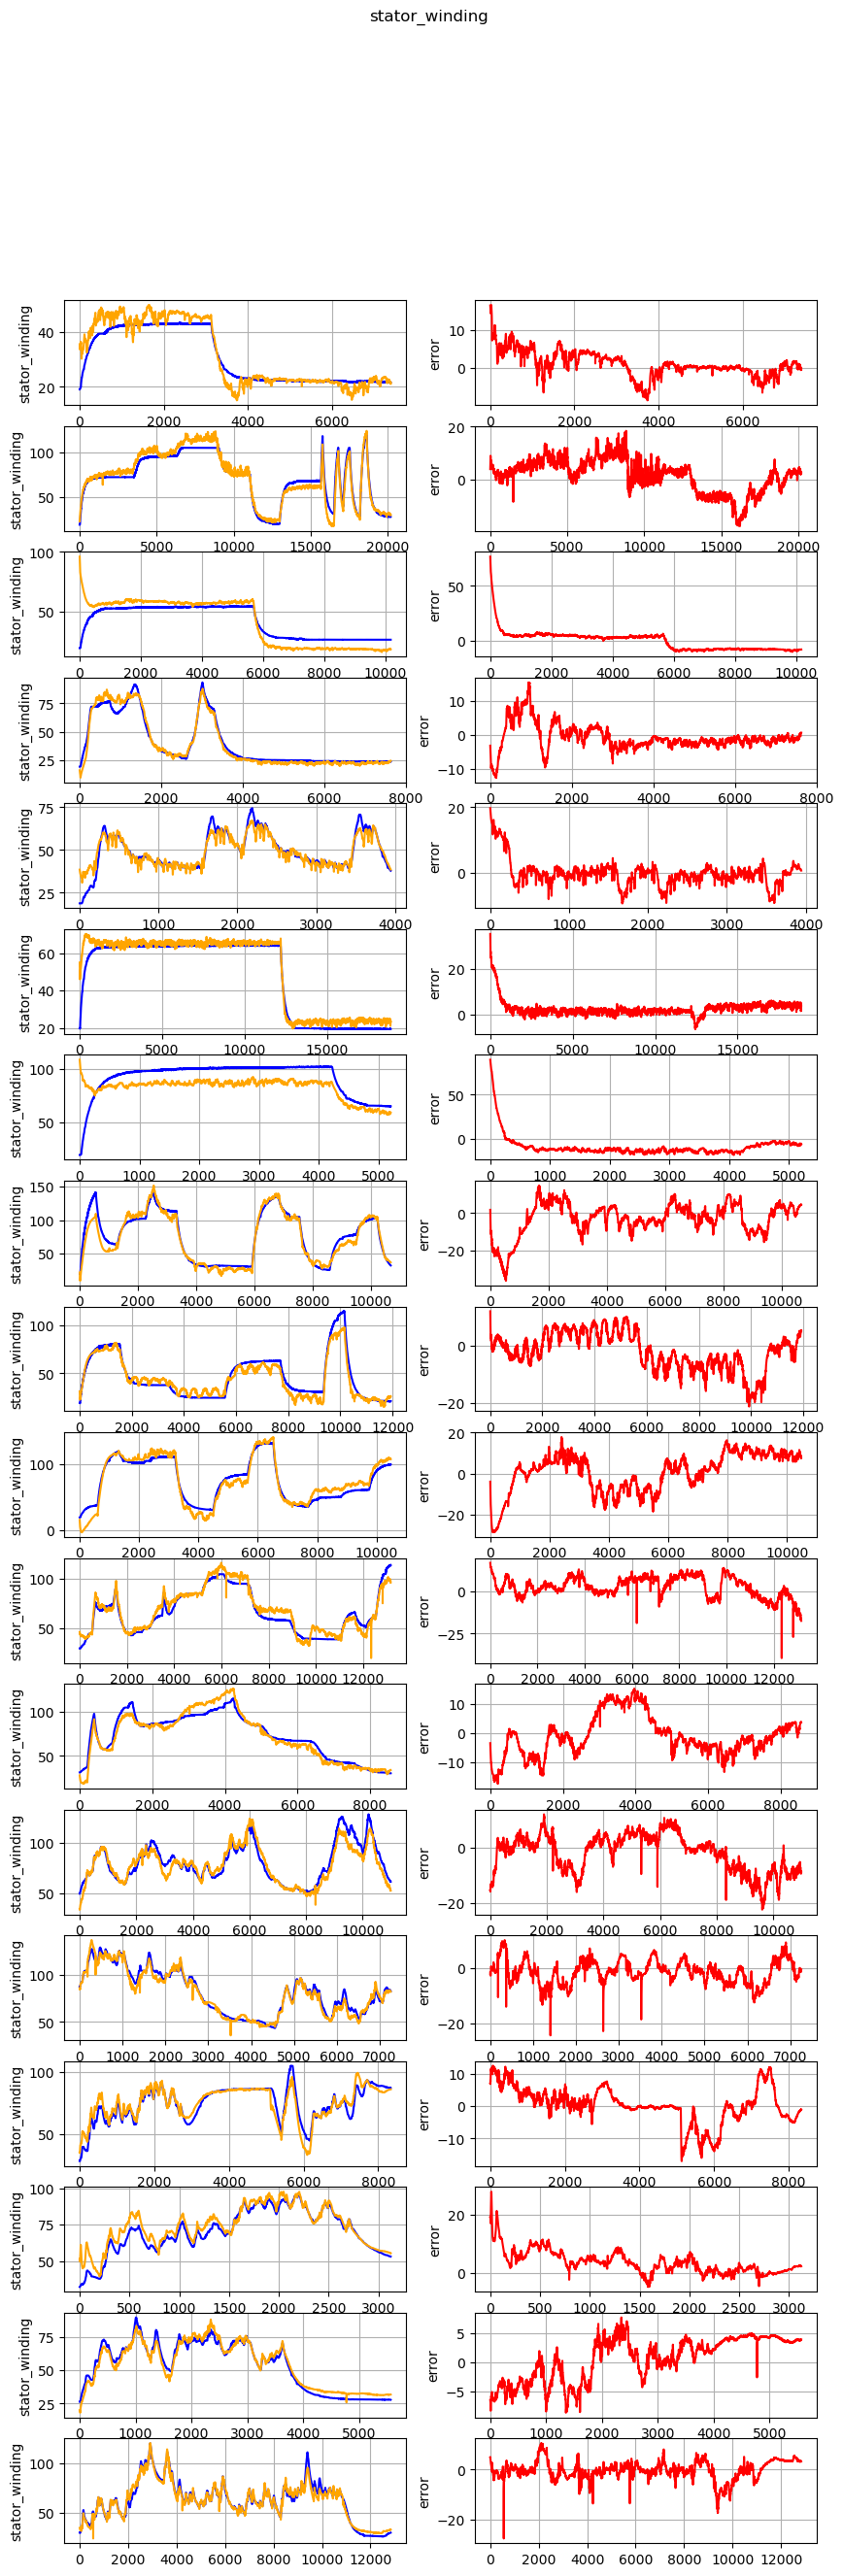

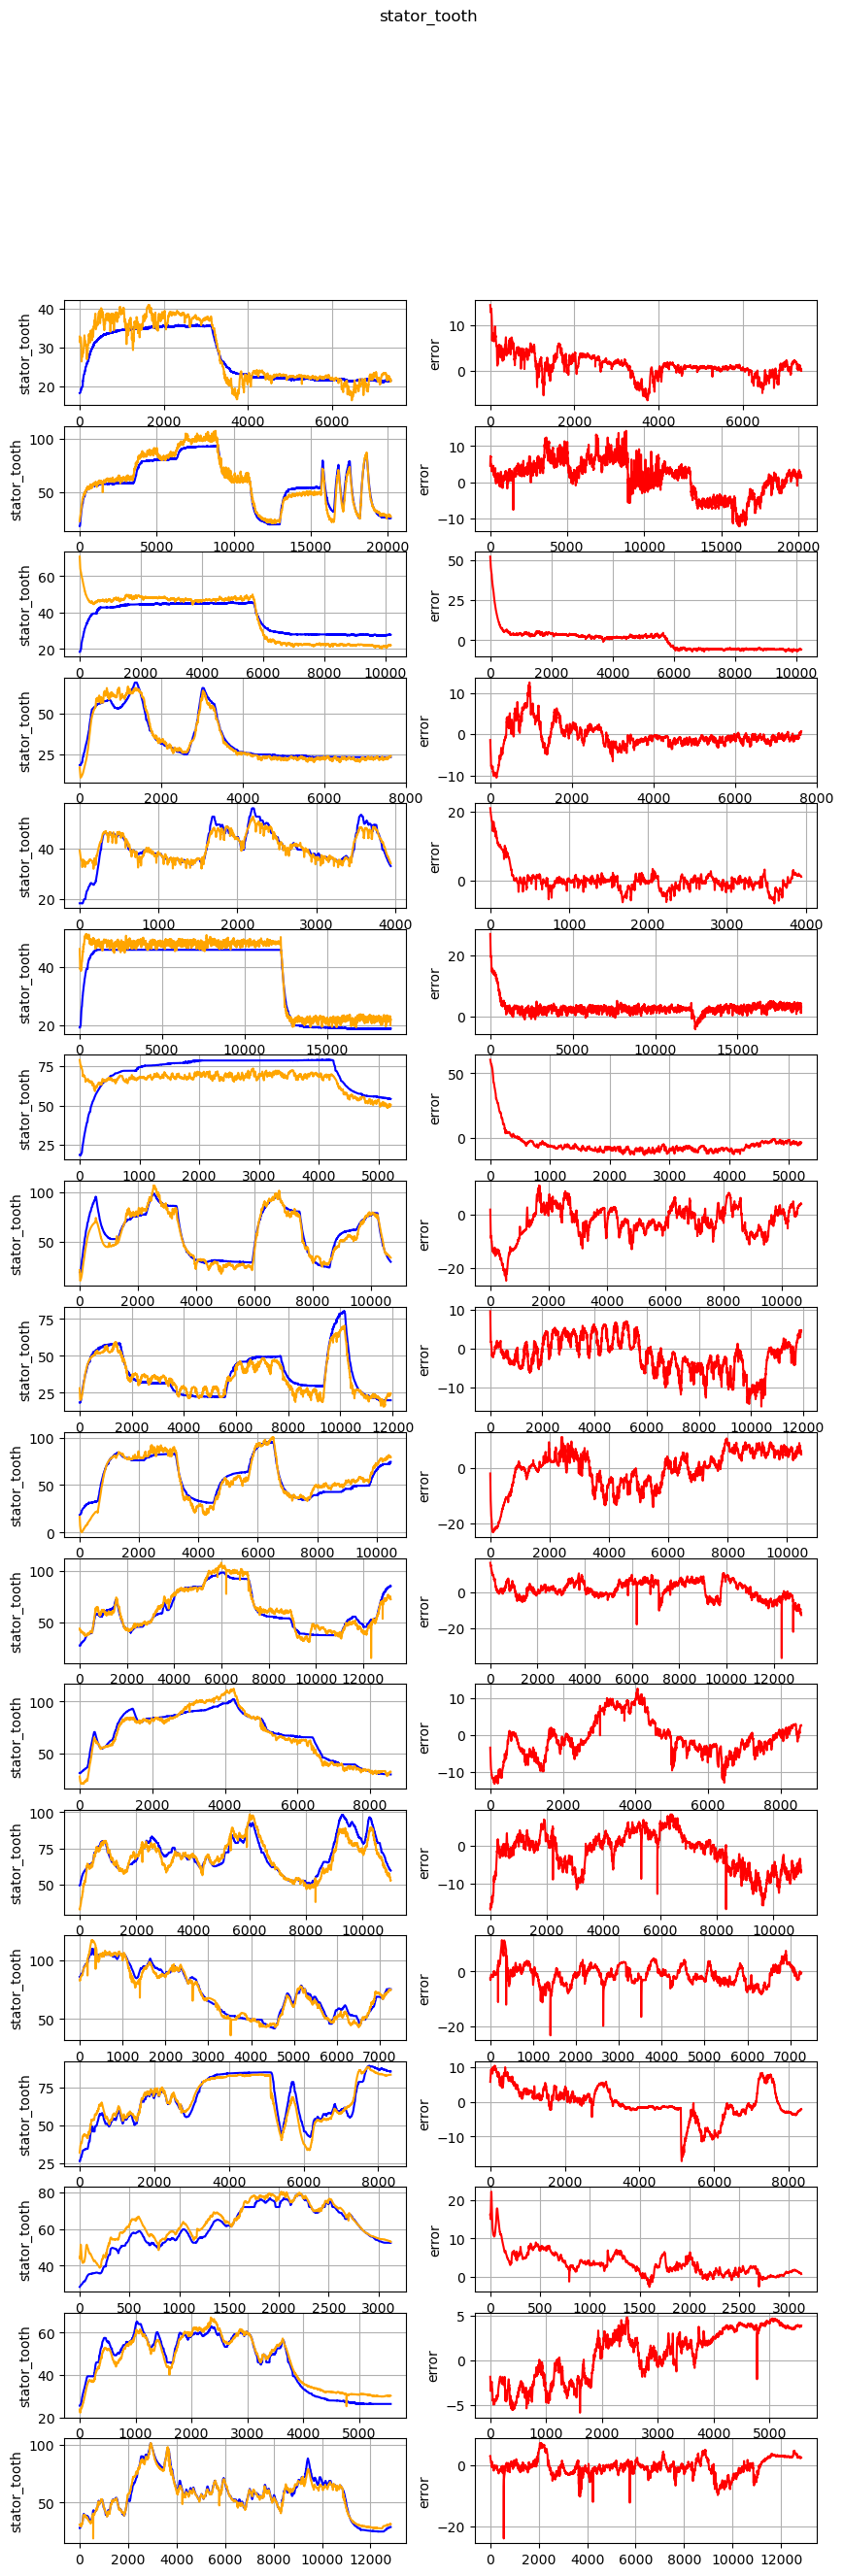

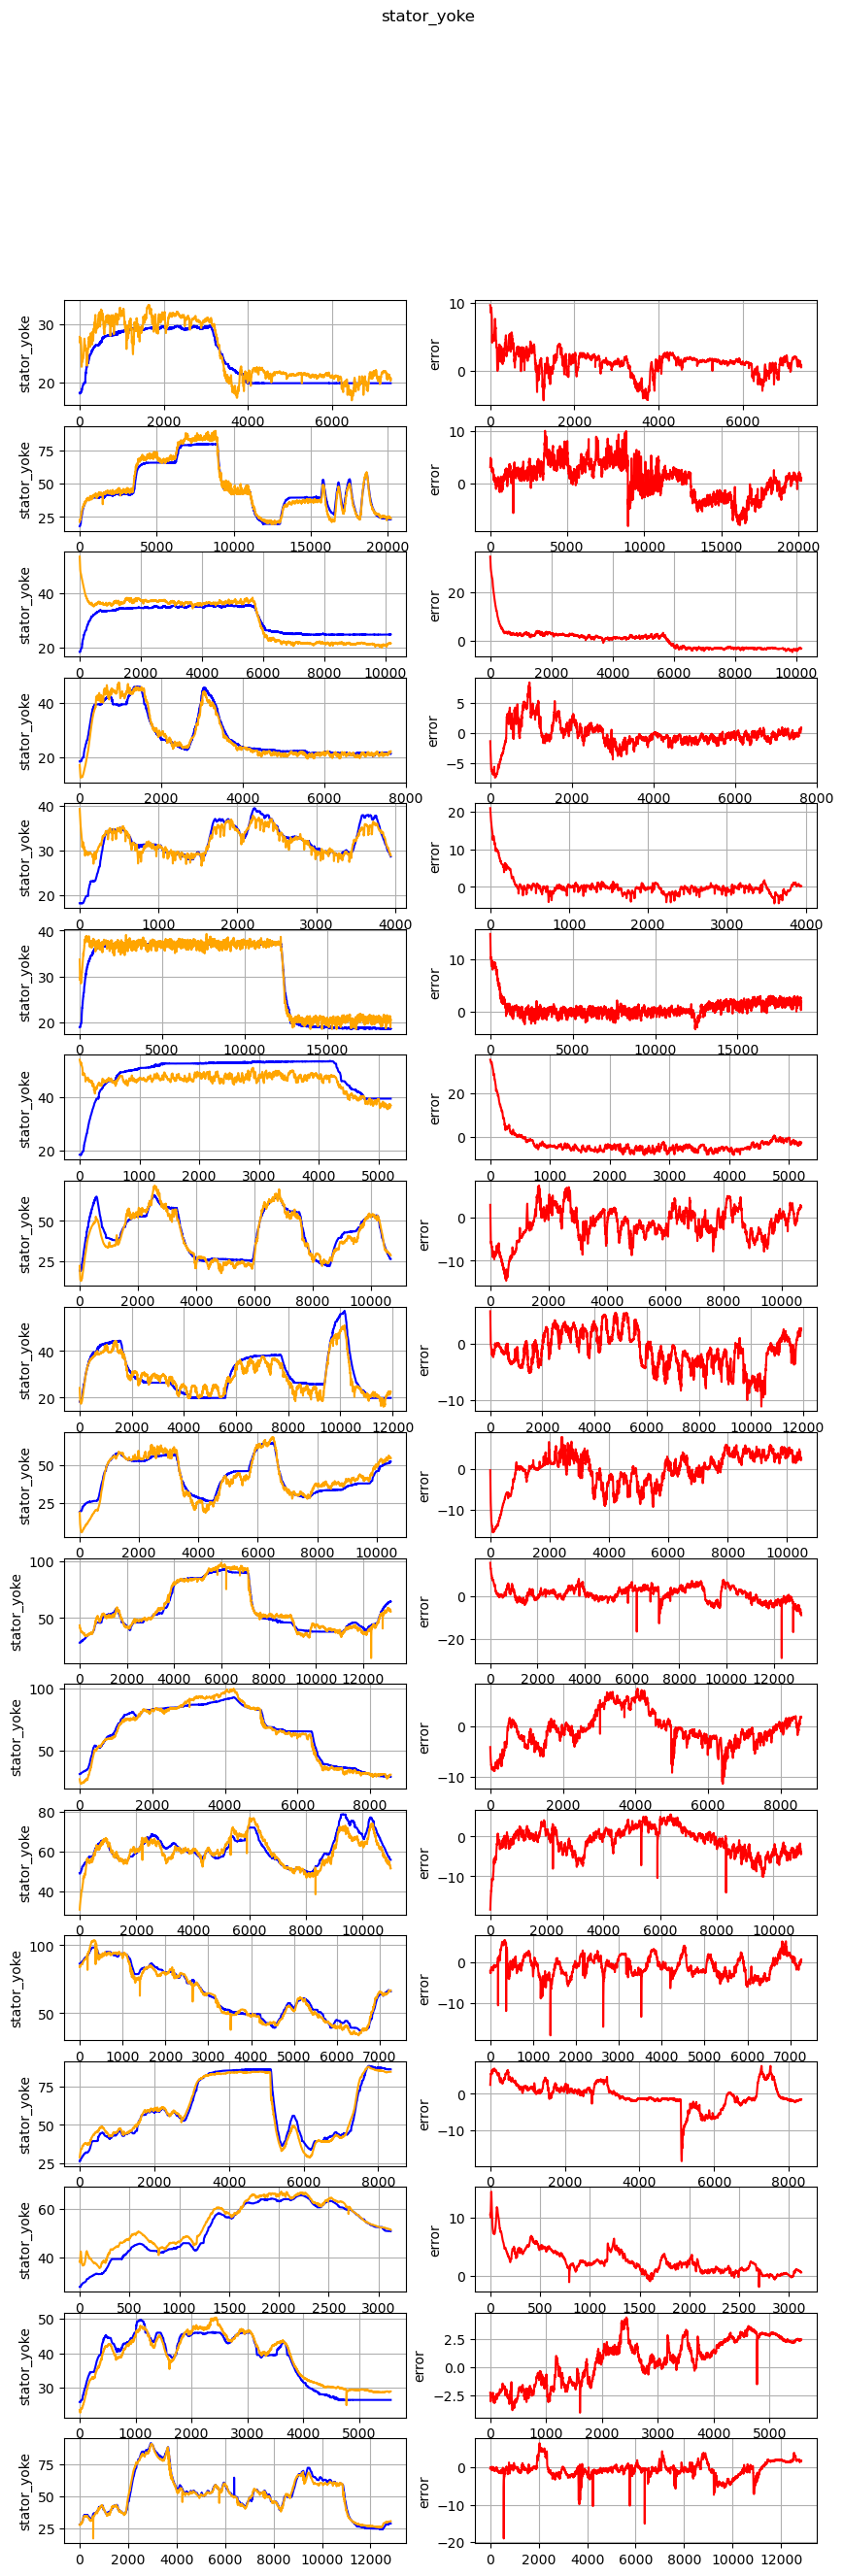

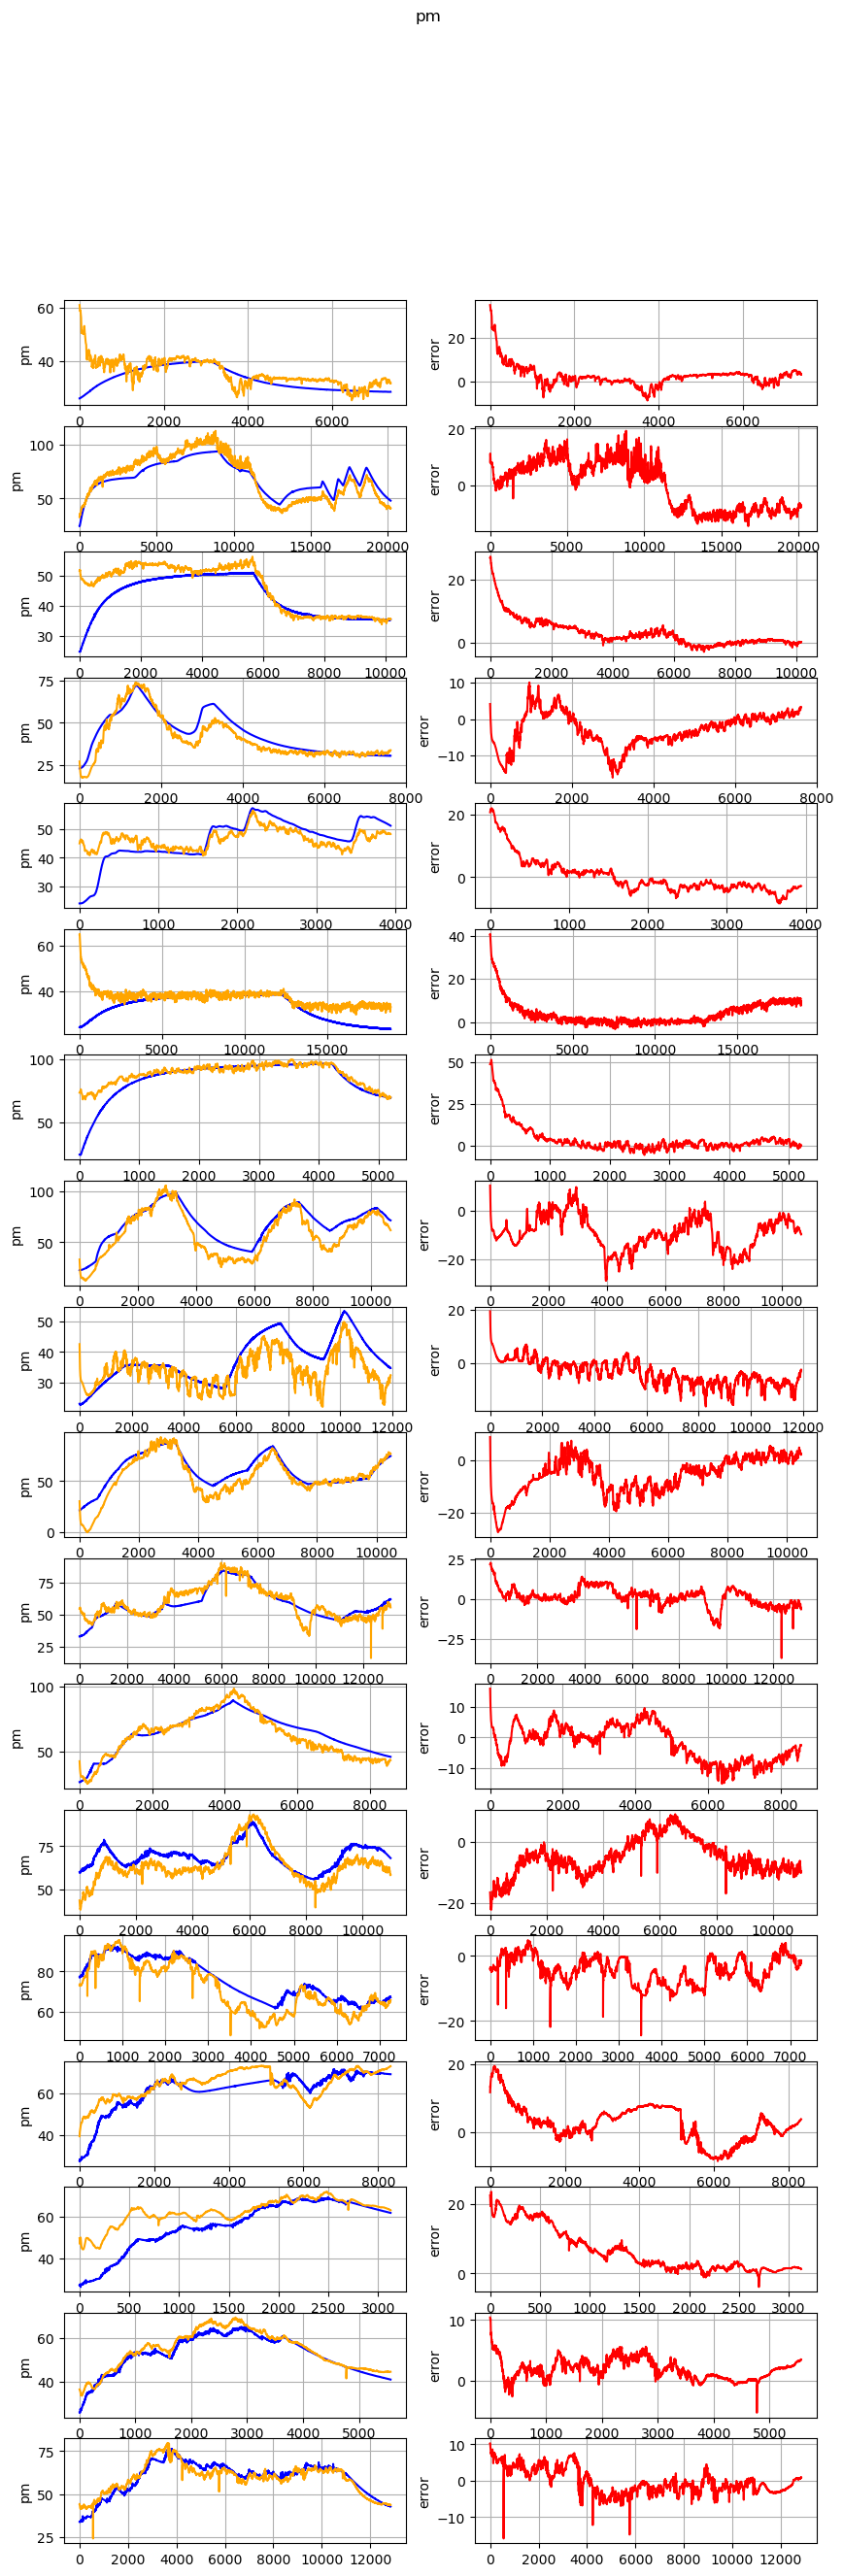

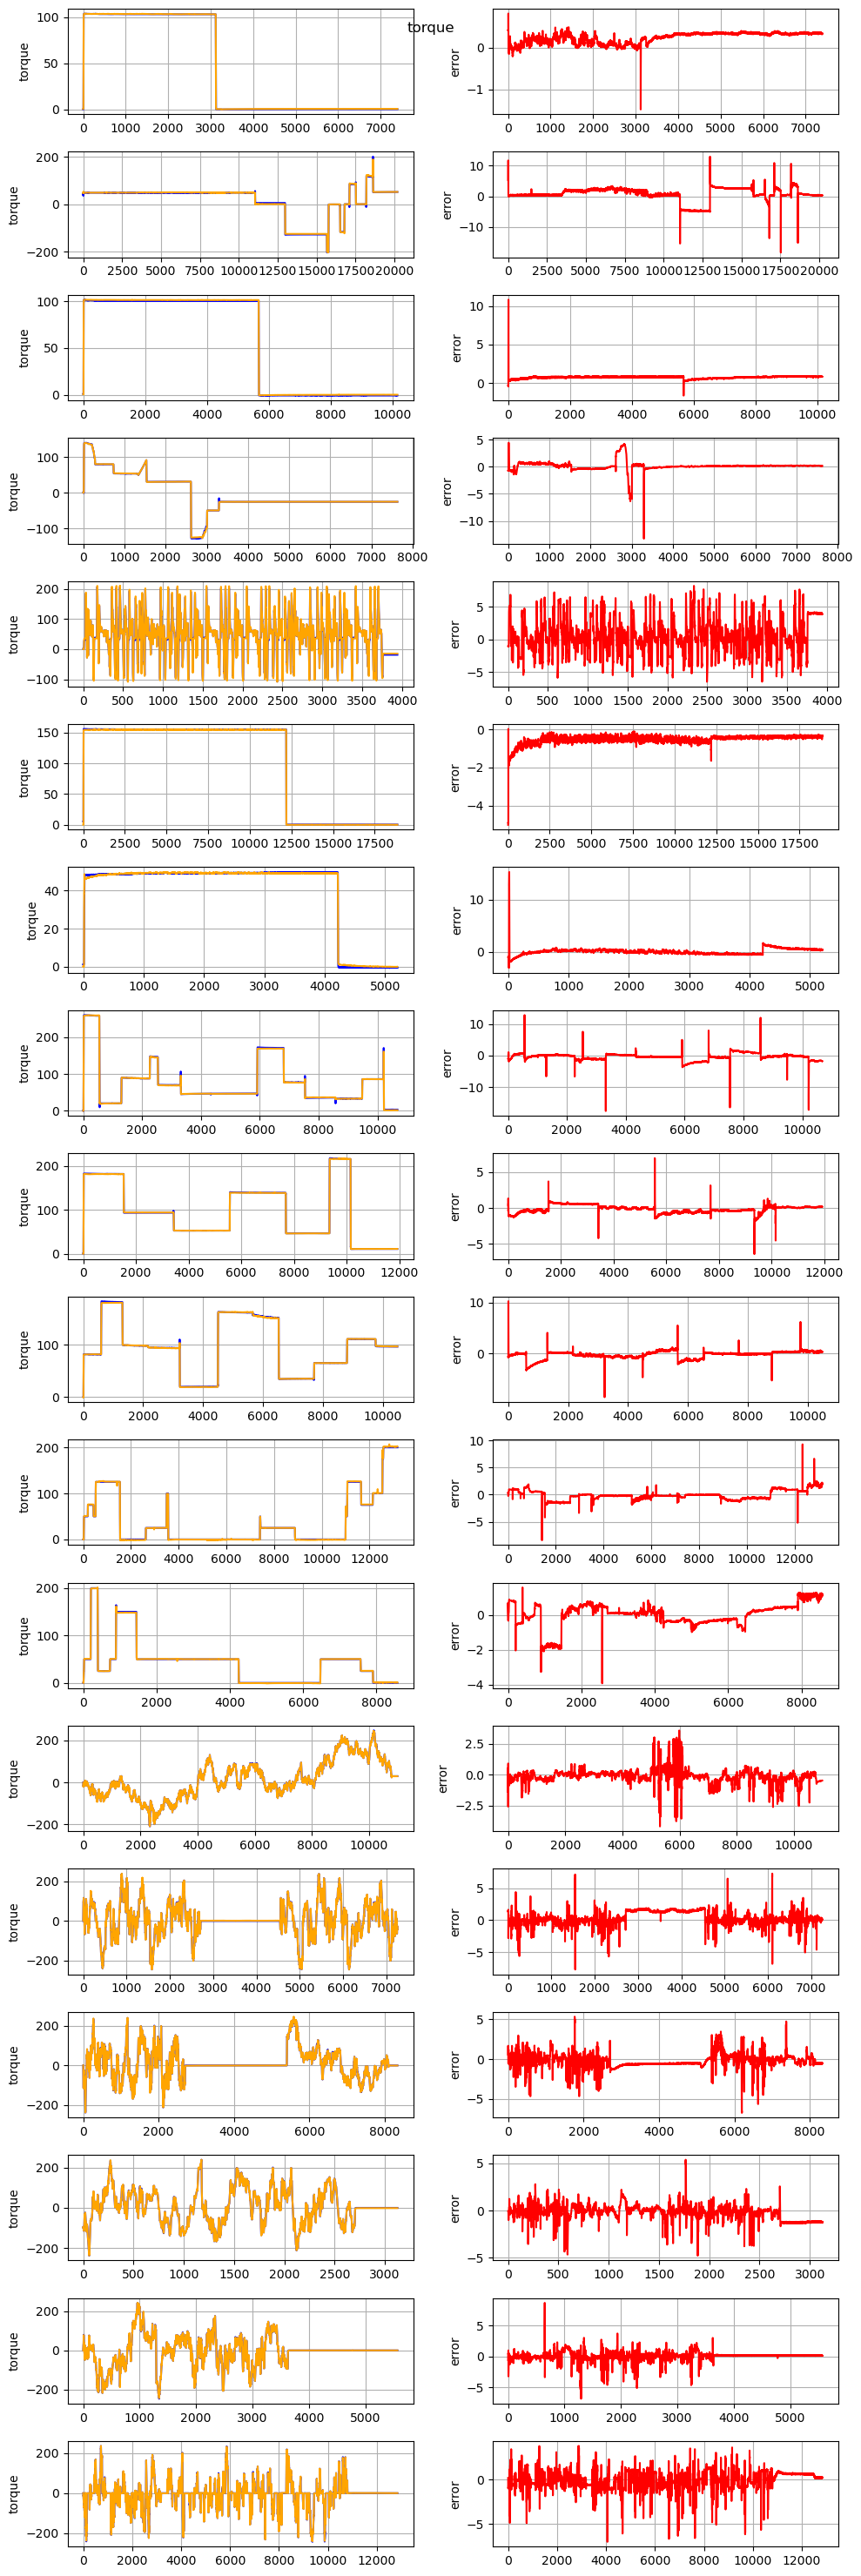

In [113]:
# close any open figures
plt.close('all')

# get profile_ids from test set
test_ids = np.unique(y_test.index.get_level_values(0))

# reset indices
y_test_reset = y_test.reset_index()

# create subplots
for feat in y_test.columns:
    # get figure and axes
    fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(10, 30))
    fig.suptitle(feat)
    
    # initialize counters
    i_vs = -1
    i_err = -1
    for i, ax in enumerate(axes.flat):
        # alternate plots (truth vs pred, error)
        if not (i % 2):  # even number
            # increase counter
            i_vs = i_vs + 1
            
            # get truth
            mask = y_test_reset['profile_id']==test_ids[i_vs]
            truth_df = y_test_reset[mask][['runtime',feat]]
            truth_df['set'] = 'truth'
            
            # get pred
            if feat=='torque':
                pred_df = pd.DataFrame(polynomial_model.predict(X_test_s), index=y_test.index, columns=y_test.columns).reset_index()[mask][['runtime',feat]]
                pred_df['set'] = 'pred'
            else:
                pred_df = pd.DataFrame(ewma_pred_pipeline_func(ewma_model, spans, X_test_s), index=y_test.index, columns=y_test.columns).reset_index()[mask][['runtime',feat]]
                pred_df['set'] = 'pred'
                
            # plot
            plot_feature(ax, truth_df, pred_df)
        else:  # odd number
            # increase counter
            i_err = i_err + 1
            
            # get truth
            mask = y_test_reset['profile_id']==test_ids[i_err]
            truth_df = y_test_reset[mask][['runtime',feat]]
            truth_df['set'] = 'truth'
            
            # get pred
            if feat=='torque':
                pred_df = pd.DataFrame(polynomial_model.predict(X_test_s), index=y_test.index, columns=y_test.columns).reset_index()[mask][['runtime',feat]]
                pred_df['set'] = 'pred'
            else:
                pred_df = pd.DataFrame(ewma_pred_pipeline_func(ewma_model, spans, X_test_s), index=y_test.index, columns=y_test.columns).reset_index()[mask][['runtime',feat]]
                pred_df['set'] = 'pred'
                
            # plot
            plot_error(ax, truth_df, pred_df)
          
# show plots
plt.tight_layout()
plt.show()

The EWMA model and the Polynomial model are doing a great job at capturing the trends in the target features and closely match their magnitudes for almost all points of each measurement session collected during testing. This information strongly suggests that the target features of the motor could indeed be predicted from measurements.

Future work would include:
1. determining how these models could be implemented in real-time and how that would effect their accuracy.
2. finding a way to lower error spikes at the beginning of each new motor session